### FRE-GY 6901, Volatility Models, Master of Science in Financial Engineering, NYU Tandon, Fall 2024
# Computing assignment 1 (part II of Homework week 5)

### Due Date: 11:59 PM Monday, October 14, 2024
You should turn in the notebook on Brightspace.

The computing assignment is about the two-factor Bergomi model.

Please comment your code properly.

Before you turn in the notebook, press the "Run all cells" button in the toolbar, and make sure all the calculation results and graphs are produced correctly in a reasonable time frame, and then save the notebook.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4.8, 3.2)

from math import exp, sqrt, log, pi, sin, cos, atan, tan

In [2]:
from py_vollib.black_scholes.implied_volatility import implied_volatility
vec_find_vol_rat = np.vectorize(implied_volatility)   # a better imp vol estimator based on P Jäckel Let's be rational

# The two-factor Bergomi model
The objective of the homework is to price SPX options, VIX futures, and VIX options in the two-factor Bergomi model

$$\begin{eqnarray}
S_t &=& S_0 \exp\left(\int_0^t \sqrt{\xi_s^s}dW_s - \frac{1}{2}\int_0^t \xi_s^s ds \right) \\
    X_t^j &=& e^{-k_j t} \int_0^t e^{k_j s} \, dZ^j_s, \qquad j\in\{1,2\} \\
\alpha_\theta &=& \left( (1-\theta)^2 +\theta^2+2 \rho_{12}\theta(1-\theta)\right)^{-1/2} \\
x_t^u &=& \alpha_\theta \left((1-\theta)e^{-k_1(u-t)}X_t^1 + \theta e^{-k_2(u-t)}X_t^2 \right) \\
\xi_t^u &=& \xi_0^u g^u(t,x_t^u) \;\; = \;\;\xi_0^u f^u(t,X_t^1,X_t^2) \\
g^u(t,x) &=& \exp\left(\omega x - \frac{\omega^2}{2}\chi(t,u)\right) \\
\chi(t,u) &=& \alpha_\theta^2\left( (1-\theta)^2e^{-2k_1(u-t)} \text{Var}(X_t^1) + \theta^2e^{-2k_2(u-t)} \text{Var}(X_t^2) \right. \\
&& \left. + 2\theta(1-\theta)e^{-(k_1+k_2)(u-t)}\text{Cov}(X_t^1,X_t^2)\right) \\
d\langle W,Z^1\rangle_t &=& \rho_{S1} dt \\
d\langle W,Z^2\rangle_t &=& \rho_{S2} dt \\
d\langle Z^1,Z^2\rangle_t &=& \rho_{12} dt \\
\end{eqnarray}
$$

## Pricing SPX options

1. By doing a Cholesky decomposition, give a necessary and sufficient condition (*) on $\rho_{S1},\rho_{S2},\rho_{12}$ so that
$$\begin{bmatrix}1 & \rho_{S1} & \rho_{S2}\\ \rho_{S1} & 1 & \rho_{12} \\ \rho_{S2} & \rho_{12} & 1\end{bmatrix}$$
is a correlation matrix.

Solution of 1:

To be a correlation matrix,  1) all entries should be in [-1, 1], i.e.
$$\rho_{S1}, \rho_{S2}, \rho_{12} \in [-1, 1]$$
and 2) the matrix should be positive semi-definite, i.e. 
$$
\left | \begin{matrix} 1 & \rho_{S1} \\ \rho_{S1} & 1 \end{matrix} \right | 
= 1-\rho_{S1}^2
\geq 0,  \rho_{S1} \in [-1, 1]\\
\left | \begin{matrix} 1 & \rho_{S2} \\ \rho_{S2} & 1 \end{matrix} \right | 
= 1-\rho_{S2}^2
\geq 0, \rho_{S2} \in [-1, 1]\\
\left | \begin{matrix} 1 & \rho_{12} \\ \rho_{12} & 1 \end{matrix} \right | 
= 1-\rho_{12}^2
\geq 0, \rho_{12} \in [-1, 1]\\
$$
$$\left | \begin{matrix} 1 & \rho_{S1} & \rho_{S2}\\ \rho_{S1} & 1 & \rho_{12} \\ \rho_{S2} & \rho_{12} & 1 \end{matrix} \right | \\ 
= 1-\rho_{12}^2 -\rho_{S1}^2 - \rho_{S2}^2 + 2\rho_{12}\rho_{S1}\rho_{S2}
\geq 0$$

Cholesky decomposition of a given matrix can be computed using `numpy.linalg.cholesky` in Python.

Below we describe a Monte Carlo simulation scheme for the two-factor Bergomi model.

First we discretize the interval $(0,T)$ into subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$, and set $\Delta t_i=t_i-t_{i-1}$. 

The Ornstein-Uhlenbeck process $X^j$ is explicitly solvable:
\begin{equation}
X^j_{t_i}=e^{-k_j\Delta t_i}X^j_{t_{i-1}}+\int_{t_{i-1}}^{t_i} e^{-k_j\left(t_i-s\right)}dZ_s^{j}.
\end{equation}
so that paths of $X^j$ can be simulated exactly.

To simulate the spot process $S$, we use the Euler scheme on the log (by abuse of notation, below, S will denote the Euler scheme, not the true asset price process):
$$\log S_{t_i}-\log S_{t_{i-1}}=-\frac{1}{2}\xi_{t_{i-1}}^{t_{i-1}}\Delta t_i+\sqrt{\xi_{t_{i-1}}^{t_{i-1}}}\int_{t_{i-1}}^{t_i}dW_t$$

Thus given $(S_{t_{i-1}},X^1_{t_{i-1}},X^2_{t_{i-1}})$, $(\log S_{t_i},X^1_{t_i},X^2_{t_i})$ is a Gaussian vector.

2. Compute the mean vector and covariance matrix of this Gaussian vector.

This is what we will use to iteratively simulate $(\log S_{t_i},X^1_{t_i},X^2_{t_i})$.

3. Fill in the blanks in the code below.


Solution of 2:

Given information till $t_{i-1}$:
$$
E(X^j_{t_i})=e^{-k_j\Delta t_i}X^j_{t_{i-1}}\\
E(\log S_{t_{i}})= \log S_{t_{i-1}}-\frac{1}{2}\xi_{t_{i-1}}^{t_{i-1}}\Delta t_i\\
Var(X^j_{t_i}) = E(X^{j 2}_{t_i}) - E(X^j_{t_i})^2 = \frac{1}{2k_j} (1-e^{-2k_j\Delta t_i})\\
Var(\log S_{t_{i}}) = E(\log^2 S_{t_i})-E(\log S_{t_{i}})^2 =  \xi_{t_{i-1}}^{t_{i-1}}\Delta t_i\\
Cov(X_{t_i}^1, X_{t_i}^2) =  \frac{\rho_{12}}{k_1+k_2} (1-e^{-(k_1+k_2)\Delta t_i}) \\
Cov(X_{t_i}^j, \log S_{t_{i}}) = E(X_{t_i}^j \log S_{t_{i}}) - E(X_{t_i}^j)E(\log S_{t_{i}}) = \sqrt{\xi_{t_{i-1}}^{t_{i-1}}} \rho_{Sj} \frac{1}{k_j}(1-e^{-k_j \Delta t_i})\\
$$
Hence, 
$$
E((\log S_{t_i},X^1_{t_i},X^2_{t_i})) = (\log S_{t_{i-1}}-\frac{1}{2}\xi_{t_{i-1}}^{t_{i-1}}\Delta t_i,\  e^{-k_1\Delta t_i}X^1_{t_{i-1}},\  e^{-k_2\Delta t_i}X^2_{t_{i-1}})\\

Cov(\log S_{t_i},X^1_{t_i},X^2_{t_i}) = \begin{bmatrix} 
\xi_{t_{i-1}}^{t_{i-1}}\Delta t_i & \sqrt{\xi_{t_{i-1}}^{t_{i-1}}} \rho_{S1} \frac{1}{k_1}(1-e^{-k_1 \Delta t_i}) & \sqrt{\xi_{t_{i-1}}^{t_{i-1}}} \rho_{S2} \frac{1}{k_2}(1-e^{-k_2 \Delta t_i})\\
\sqrt{\xi_{t_{i-1}}^{t_{i-1}}} \rho_{S1} \frac{1}{k_1}(1-e^{-k_1 \Delta t_i}) & \frac{1}{2k_1} (1-e^{-2k_1\Delta t_i}) & \frac{\rho_{12}}{k_1+k_2} (1-e^{-(k_1+k_2)\Delta t_i}) \\
\sqrt{\xi_{t_{i-1}}^{t_{i-1}}} \rho_{S2} \frac{1}{k_2}(1-e^{-k_2 \Delta t_i}) & \frac{\rho_{12}}{k_1+k_2} (1-e^{-(k_1+k_2)\Delta t_i}) & \frac{1}{2k_2} (1-e^{-2k_2\Delta t_i})
\end{bmatrix}


$$



In [3]:
def two_factor_bergomi_mc(vov,k_1,k_2,theta,rho_sx1,rho_sx2,rho_x1x2,xi_0,n_steps,N_sims):
    #xi_0 is assumed costant: just a number
    #vov is the vol of variance omega

    tt = np.linspace(0., T, n_steps + 1)
    dt = T/n_steps
    
    def covar(k_1,k_2,rho,t): 

        return rho*(1-np.exp(-(k_1+k_2)*t))/(k_1+k_2)
        
    def chi_func(k_1,k_2,theta,rho_x1x2,alpha,t): # computes chi(t,t)
        chi = (1-theta)**2*covar(k_1,k_1,1.0,t)+theta**2*covar(k_2,k_2,1.0,t)+\
        2*theta*(1-theta)*covar(k_1,k_2,rho_x1x2,t)
    
        return alpha**2*chi
    
    cov_mat = np.array([[1, rho_x1x2, rho_sx1], [rho_x1x2, 1, rho_sx2], [rho_sx1, rho_sx2, 1]])
    L = np.linalg.cholesky(cov_mat)
    
    alpha = 1/sqrt((1-theta)**2+theta**2+2*rho_x1x2*theta*(1-theta))
    chi = chi_func(k_1,k_2,theta,rho_x1x2,alpha,tt)
    
    X_1 = np.zeros((n_steps+1,N_sims))
    X_2 = np.zeros((n_steps+1,N_sims))
    X = np.zeros((n_steps+1,N_sims))
    inst_vol = np.zeros((n_steps+1,N_sims))
    logS = np.zeros((n_steps+1,N_sims))
    logS[0] = log(S_0)
    inst_vol[0] = sqrt(xi_0)

    for i in range(n_steps):
        z1, z2, z3 = L @ np.random.normal(size=(3,N_sims)) # L @ 
        X_1[i+1] = X_1[i]*np.exp(-k_1*dt) + sqrt(covar(k_1,k_1,1,dt))*z1
        X_2[i+1] = X_2[i]*np.exp(-k_2*dt) + sqrt(covar(k_2,k_2,1,dt))*z2
        X[i+1] = alpha*((1-theta)*X_1[i+1] + theta*X_2[i+1])
        inst_vol[i+1] = sqrt(xi_0)*np.exp(vov*X[i+1]/2-vov**2/4*chi[i+1])

        logS[i+1] = logS[i] - 0.5*inst_vol[i]**2*dt + inst_vol[i]*sqrt(dt)*z3
        
    return np.exp(logS[-1])

In [4]:
vov = 4 
k_1 = 20
k_2 = 1.5
theta = 0.75
xi_0 = 0.025
rho_sx1,rho_sx2,rho_x1x2 = -0.8, -0.7, 0.7
T = 1

In [5]:
S_0 = 100

In [6]:
n_steps = 500
N_sims = 100000

In [7]:
ST = two_factor_bergomi_mc(vov,k_1,k_2,theta,rho_sx1, rho_sx2, rho_x1x2,xi_0,n_steps,N_sims)

In [8]:
lm = np.linspace(-0.6,0.4,100) # log-moneyness
strike_array = np.exp(lm)*S_0

In [9]:
opt_price = np.average(np.maximum(ST-strike_array.reshape(-1,1),0),axis=1)
iv = vec_find_vol_rat(opt_price, S_0, strike_array, T, 0, 'c')

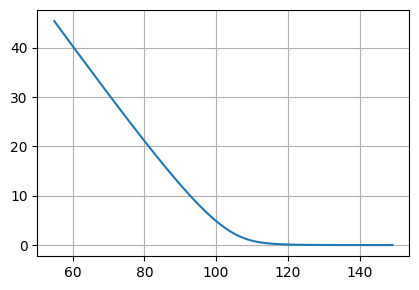

In [10]:
plt.plot(strike_array,opt_price)
plt.grid()

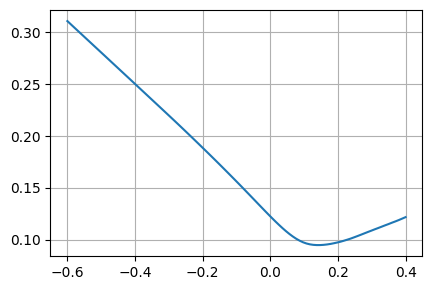

In [11]:
plt.plot(lm,iv)
plt.grid()

4. Vary the parameters vov, k_1, k_2, theta, rho_sx1, rho_sx2, rho_x1x2 and T and comment on the impact on the smile

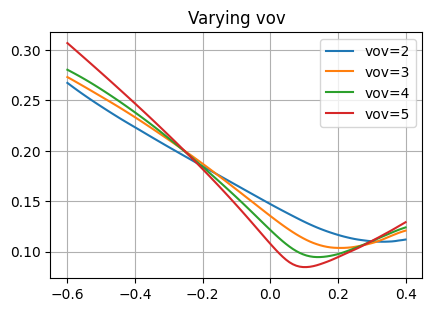

In [12]:
# Varying vov
vovs = [2, 3, 4, 5]
vov_results = np.zeros((len(vovs), lm.shape[0]))
for i,vov_new in enumerate(vovs):
    ST_new = two_factor_bergomi_mc(vov_new,k_1,k_2,theta,rho_sx1, rho_sx2, rho_x1x2,xi_0,n_steps,N_sims)
    opt_price_new = np.average(np.maximum(ST_new-strike_array.reshape(-1,1),0),axis=1)
    iv_new = vec_find_vol_rat(opt_price_new, S_0, strike_array, T, 0, 'c')
    vov_results[i] = iv_new

plt.plot(lm, vov_results.T)
plt.legend([f'vov={v}' for v in vovs])
plt.title("Varying vov")
plt.grid()

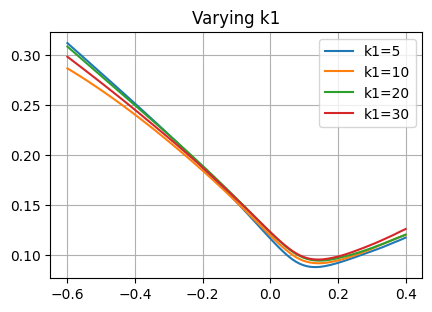

In [13]:
# Varying k_1
k_1s = [5, 10, 20, 30]
k_1_results = np.zeros((len(k_1s), lm.shape[0]))
for i,k_1_new in enumerate(k_1s):
    ST_new = two_factor_bergomi_mc(vov,k_1_new,k_2,theta,rho_sx1, rho_sx2, rho_x1x2,xi_0,n_steps,N_sims)
    opt_price_new = np.average(np.maximum(ST_new-strike_array.reshape(-1,1),0),axis=1)
    iv_new = vec_find_vol_rat(opt_price_new, S_0, strike_array, T, 0, 'c')
    k_1_results[i] = iv_new

plt.plot(lm, k_1_results.T)
plt.legend([f'k1={v}' for v in k_1s])
plt.title("Varying k1")
plt.grid()

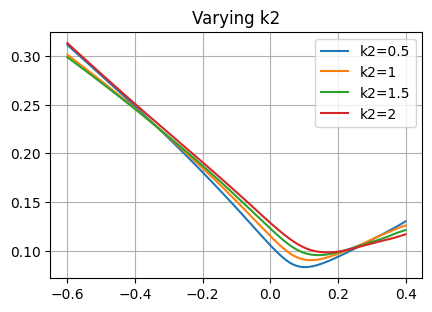

In [14]:
# Varying k_2
k_2s = [0.5, 1, 1.5, 2]
k_2_results = np.zeros((len(k_2s), lm.shape[0]))
for i,k_2_new in enumerate(k_2s):
    ST_new = two_factor_bergomi_mc(vov,k_1,k_2_new,theta,rho_sx1, rho_sx2, rho_x1x2,xi_0,n_steps,N_sims)
    opt_price_new = np.average(np.maximum(ST_new-strike_array.reshape(-1,1),0),axis=1)
    iv_new = vec_find_vol_rat(opt_price_new, S_0, strike_array, T, 0, 'c')
    k_2_results[i] = iv_new

plt.plot(lm, k_2_results.T)
plt.legend([f'k2={v}' for v in k_2s])
plt.title("Varying k2")
plt.grid()

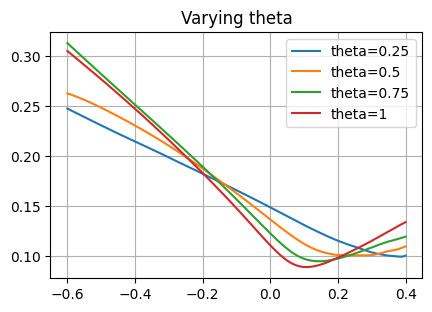

In [15]:
# Varying theta
thetas = [0.25, 0.5, 0.75, 1]
theta_results = np.zeros((len(thetas), lm.shape[0]))
for i,theta_new in enumerate(thetas):
    ST_new = two_factor_bergomi_mc(vov,k_1,k_2,theta_new,rho_sx1, rho_sx2, rho_x1x2,xi_0,n_steps,N_sims)
    opt_price_new = np.average(np.maximum(ST_new-strike_array.reshape(-1,1),0),axis=1)
    iv_new = vec_find_vol_rat(opt_price_new, S_0, strike_array, T, 0, 'c')
    theta_results[i] = iv_new

plt.plot(lm, theta_results.T)
plt.legend([f'theta={v}' for v in thetas])
plt.title("Varying theta")
plt.grid()

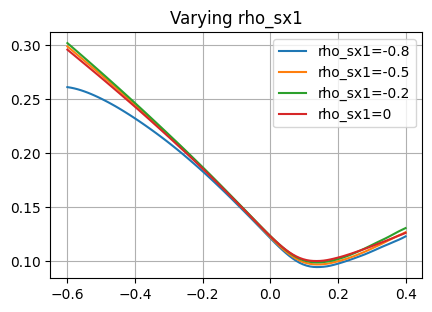

In [16]:
# Varying rho_sx1
rho_sx1s = [-0.8, -0.5, -0.2, 0]
rho_sx1_results = np.zeros((len(rho_sx1s), lm.shape[0]))
for i,rho_sx1_new in enumerate(rho_sx1s):
    ST_new = two_factor_bergomi_mc(vov,k_1,k_2,theta,rho_sx1_new, rho_sx2, rho_x1x2,xi_0,n_steps,N_sims)
    opt_price_new = np.average(np.maximum(ST_new-strike_array.reshape(-1,1),0),axis=1)
    iv_new = vec_find_vol_rat(opt_price_new, S_0, strike_array, T, 0, 'c')
    rho_sx1_results[i] = iv_new

plt.plot(lm, rho_sx1_results.T)
plt.legend([f'rho_sx1={v}' for v in rho_sx1s])
plt.title("Varying rho_sx1")
plt.grid()

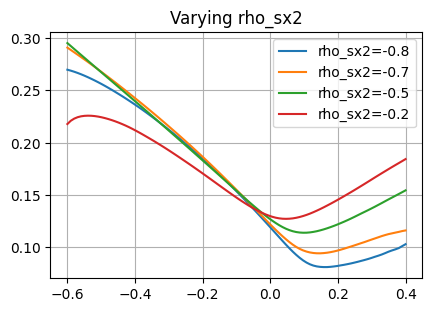

In [17]:
# Varying rho_sx2
rho_sx2s = [-0.8, -0.7, -0.5, -0.2]
rho_sx2_results = np.zeros((len(rho_sx2s), lm.shape[0]))
for i,rho_sx2_new in enumerate(rho_sx2s):
    ST_new = two_factor_bergomi_mc(vov,k_1,k_2,theta,rho_sx1, rho_sx2_new, rho_x1x2,xi_0,n_steps,N_sims)
    opt_price_new = np.average(np.maximum(ST_new-strike_array.reshape(-1,1),0),axis=1)
    iv_new = vec_find_vol_rat(opt_price_new, S_0, strike_array, T, 0, 'c')
    rho_sx2_results[i] = iv_new

plt.plot(lm, rho_sx2_results.T)
plt.legend([f'rho_sx2={v}' for v in rho_sx2s])
plt.title("Varying rho_sx2")
plt.grid()

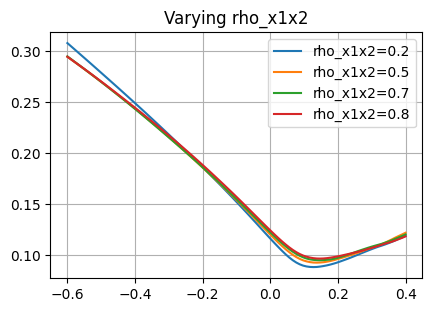

In [18]:
# Varying rho_x1x2
rho_x1x2s = [0.2, 0.5, 0.7, 0.8]
rho_x1x2_results = np.zeros((len(rho_x1x2s), lm.shape[0]))
for i,rho_x1x2_new in enumerate(rho_x1x2s):
    ST_new = two_factor_bergomi_mc(vov,k_1,k_2,theta,rho_sx1, rho_sx2, rho_x1x2_new,xi_0,n_steps,N_sims)
    opt_price_new = np.average(np.maximum(ST_new-strike_array.reshape(-1,1),0),axis=1)
    iv_new = vec_find_vol_rat(opt_price_new, S_0, strike_array, T, 0, 'c')
    rho_x1x2_results[i] = iv_new

plt.plot(lm, rho_x1x2_results.T)
plt.legend([f'rho_x1x2={v}' for v in rho_x1x2s])
plt.title("Varying rho_x1x2")
plt.grid()

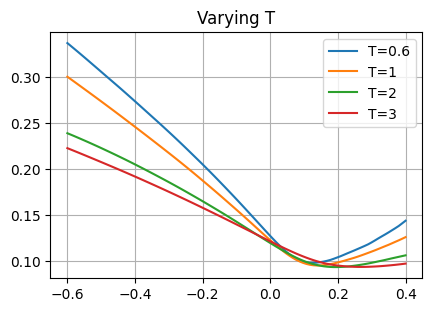

In [19]:
# varying T
Ts = [0.6, 1, 2, 3]
T_results = np.zeros((len(Ts), lm.shape[0]))
for i,T in enumerate(Ts):
    ST_new = two_factor_bergomi_mc(vov,k_1,k_2,theta,rho_sx1, rho_sx2, rho_x1x2,xi_0,n_steps,N_sims)
    opt_price_new = np.average(np.maximum(ST_new-strike_array.reshape(-1,1),0),axis=1)
    iv_new = vec_find_vol_rat(opt_price_new, S_0, strike_array, T, 0, 'c')
    T_results[i] = iv_new

plt.plot(lm, T_results.T)
plt.legend([f'T={v}' for v in Ts])
plt.title("Varying T")
plt.grid()

Varying `vov`, `theta` impacts the shape of the smile: the absolute range of the smile gets larger and the slope gets steeper when vov is high, or theta is high. Varying `k_1` influences the smile of low moneyness(smaller K), varying `k_2` influences the smile of high moneyness(larger K). `rho_sx1` and `rho_x1x2` have limited impact on the smile, while `rho_sx2` has larger impact on its shape, especially in high moneyness. Varifying `T` also impacts the smile: volatility becomes higher when T is smaller.

## Pricing VIX options

Recall that in variance curve models,
$$\text{VIX}^2_T = \frac{1}{\tau}\int_T^{T+\tau} \xi_T^u du$$
where $\tau=30/365$ (30 days). As a result, in the two-factor Bergomi model, there exists a function $\psi$ such that
$$\text{VIX}_T = \psi(T,X_T^1,X_T^2)$$

5. Write down the function $\psi$.

Since the vector $(X_T^1,X_T^2)$ is Gaussian, the price $\mathbb{E}[h(\text{VIX}_T)]$ of a VIX option $h(\text{VIX}_T)$ can very efficiently be estimated by a Gauss-Hermite quadrature; see 
https://en.wikipedia.org/wiki/Gaussian_quadrature and 
https://numpy.org/doc/stable/reference/generated/numpy.polynomial.hermite.hermgauss.html

6. Using this method, price a VIX future maturing at $T$ (choose $T=1/12$ (1 month), $2/12$, $3/12$, $4/12$) and VIX call options with the same maturity; take strikes with log-moneyness from -0.2 to 2.5, based on the price of the VIX future. Vary the number of points in the quadrature. Plot the VIX smile, using the Black formula (with spot value the value of the VIX future) to compute the VIX implied volatilities. Comment on the impact of the vol-of-vol on the price of the VIX future and on the VIX implied volatilities; in the one-factor Bergomi model ($\theta=0$), comment on the impact of the mean reversion on the VIX implied volatilities.

Solution of 5:
$$ 
\text{VIX}_T = \psi(T, X_T^1, X_T^2) = \sqrt{\frac{1}{\tau} \int_T^{T+\tau}\xi_T^u du} \\
= \sqrt{\frac{1}{\tau} \int_T^{T+\tau}\xi_0^u exp(\omega X_T^u - \frac{\omega^2}{2}\chi(T,u)) du}\\
where \ 
X_t^u = \alpha_\theta \left((1-\theta)e^{-k_1(u-t)}X_t^1 + \theta e^{-k_2(u-t)}X_t^2 \right) \\
\chi(t,u) = \alpha_\theta^2\left( (1-\theta)^2e^{-2k_1(u-t)} \text{Var}(X_t^1) + \theta^2e^{-2k_2(u-t)} \text{Var}(X_t^2) \right. \left. + 2\theta(1-\theta)e^{-(k_1+k_2)(u-t)}\text{Cov}(X_t^1,X_t^2)\right)
$$

In [20]:
# Solution of 6
vov = 4 
k_1 = 20
k_2 = 1.5
theta = 0.75
xi_0 = 0.025
tau = 30/365
rho_x1x2 = 0.7
T = 1/12
S_0 = 100

log_moneyness = np.linspace(-0.2, 2.5, 100)

In [21]:
def covar(k_1,k_2,rho,t): 
    return rho*(1-np.exp(-(k_1+k_2)*t))/(k_1+k_2)

def chi_ut(k_1,k_2,theta,rho_x1x2,alpha,u,t): 
    "computes chi(u,t), not vectorized"
    chi = (1-theta)**2*covar(k_1,k_1,1.0,t)*exp(-2*k_1*(u-t))+theta**2*covar(k_2,k_2,1.0,t)*exp(-2*k_2*(u-t))+\
    2*theta*(1-theta)*covar(k_1,k_2,rho_x1x2,t)*exp(-(k_1+k_2)*(u-t))
    return alpha**2*chi

def X_ut(X1, X2, k1, k2,alpha, theta, u, t):
    return alpha*((1-theta)*exp(-k1*(u-t))*X1 + theta*exp(-k2*(u-t))*X2)

def psi(X1, X2, tau, T, xi0, vov, theta, k1, k2, rho, n_intervals=100):
    "Given X1 and X2 and parameters, returns VIX = psi(X1, X2)"  
    alpha = 1/sqrt((1-theta)**2+theta**2+2*rho_x1x2*theta*(1-theta))

    VIX = 0
    uu = np.linspace(T, T+tau, n_intervals)
    du = tau/n_intervals
    for u in uu: # using trapzoid rule to compute integral int_T^T+tau xi_T^u du
        X_uT = X_ut(X1, X2, k1, k2, alpha, theta, u, T)
        chi_uT = chi_ut(k1, k2, theta, rho, alpha, u, T)
        xi_uT = xi0*exp(vov*X_uT - vov**2/2*chi_uT)
        VIX += xi_uT*du
    
    VIX = sqrt(VIX/tau)

    return VIX

In [22]:
def VIX_Futures_Options(tau, T, xi_0, vov, theta, k_1, k_2, rho_x1x2, deg):
    x, w = np.polynomial.hermite.hermgauss(deg)

    var_X1T = covar(k_1, k_1, 1, T)
    var_X2T = covar(k_2, k_2, 1, T)
    cov_X1T_X2T = covar(k_1, k_2, rho_x1x2, T)
    Cov_matrix = np.array([[var_X1T, cov_X1T_X2T],[cov_X1T_X2T, var_X2T]])
    L = np.linalg.cholesky(Cov_matrix)
    # compute VIX FUture price
    VIX_Future = 0
    for i in range(deg):
        for j in range(deg):
            Z = np.array([x[i], x[j]])
            Z = L @ Z
            Z1, Z2 = Z[0],Z[1]
            VIX_Future += w[i] * w[j] * psi(Z1, Z2, tau, T, xi_0, vov, theta, k_1, k_2, rho_x1x2, 100)

    VIX_Future /= np.pi

    # compute VIX options prices
    strike_array = np.exp(log_moneyness)*VIX_Future
    VIX_options = np.zeros(log_moneyness.shape)
    for i in range(deg):
        for j in range(deg):
            Z = np.array([x[i], x[j]])
            Z = L @ Z
            Z1, Z2 = Z[0],Z[1]
            for l in range(log_moneyness.shape[0]):
                VIX_options[l] += w[i] * w[j] *\
                    max(psi(Z1, Z2, tau, T, xi_0, vov, theta, k_1, k_2, rho_x1x2, 100)-strike_array[l], 0)
    VIX_options /= np.pi

    return VIX_Future, VIX_options


VIX Future price for T=0.083333: 0.13726852955886318
VIX Future price for T=0.166667: 0.12431841271390195
VIX Future price for T=0.25: 0.1152831759900651
VIX Future price for T=0.333333: 0.10873740688820689


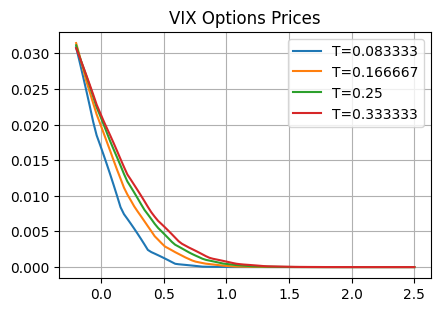

In [23]:
# compute VIX Futures and Options price for different T
Ts = [1/12, 2/12, 3/12, 4/12]
VIX_Future_prices = np.zeros(len(Ts))
VIX_Options_prices = np.zeros((len(Ts), log_moneyness.shape[0]))

for i, T_new in enumerate(Ts):
    VIX_Future_prices[i], VIX_Options_prices[i] = VIX_Futures_Options(tau, T_new, xi_0, vov, theta, k_1, k_2, rho_x1x2, 10)
    print(f'VIX Future price for T={round(T_new, 6)}: {VIX_Future_prices[i]}')

plt.plot(log_moneyness, VIX_Options_prices.T)
plt.title("VIX Options Prices")
plt.legend([f'T={round(_, 6)}' for _ in Ts])
plt.grid()

VIX Future price for deg=2: 0.1372159491638208
VIX Future price for deg=5: 0.13726852955580165
VIX Future price for deg=10: 0.13726852955886318
VIX Future price for deg=20: 0.13726852955886318


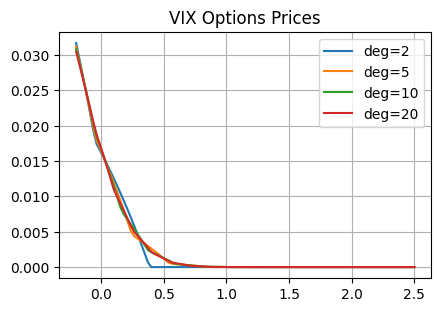

In [24]:
# varying the degree in the quadrature
degs = [2, 5, 10, 20]

VIX_Future_prices_ = np.zeros(len(degs))
VIX_Options_prices_ = np.zeros((len(degs), log_moneyness.shape[0]))

for i, deg_new in enumerate(degs):
    VIX_Future_prices_[i], VIX_Options_prices_[i] = VIX_Futures_Options(tau, T, xi_0, vov, theta, k_1, k_2, rho_x1x2, deg_new)
    print(f'VIX Future price for deg={deg_new}: {VIX_Future_prices_[i]}')

plt.plot(log_moneyness, VIX_Options_prices_.T)
plt.title("VIX Options Prices")
plt.legend([f'deg={deg_new}' for deg_new in degs])
plt.grid()


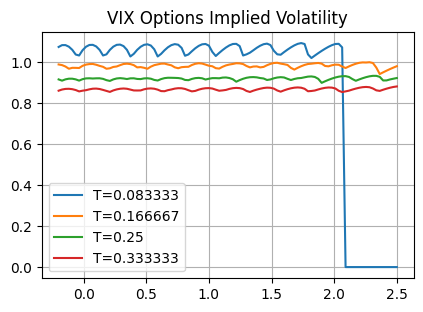

In [25]:
# compute implied volatility of VIX options
iv_T = np.zeros((len(Ts), log_moneyness.shape[0]))
for i in range(len(Ts)):
    strike_array = np.exp(log_moneyness)*VIX_Future_prices[i]
    iv_T[i] = vec_find_vol_rat(VIX_Options_prices[i], VIX_Future_prices[i], strike_array, Ts[i], 0, 'c')

plt.plot(log_moneyness, iv_T.T)
plt.title("VIX Options Implied Volatility")
plt.legend([f'T={round(_, 6)}' for _ in Ts])
plt.grid()

VIX Future price for vov=2: 0.15261370130174834
VIX Future price for vov=4: 0.13726852955886318
VIX Future price for vov=6: 0.11513796997203339
VIX Future price for vov=8: 0.09016694479144594


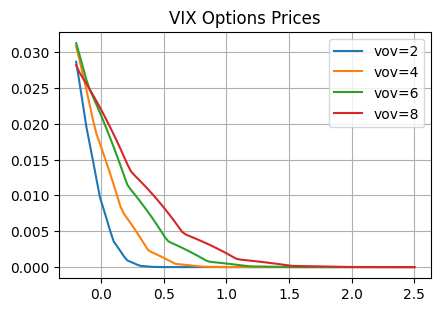

In [26]:
# varying vov to analyze its impact on VIX future prices and VIX implied volatility
vovs = [2, 4, 6, 8]

VIX_Future_prices_vov = np.zeros(len(vovs))
VIX_Options_prices_vov = np.zeros((len(vovs), log_moneyness.shape[0]))

for i, vov_new in enumerate(vovs):
    VIX_Future_prices_vov[i], VIX_Options_prices_vov[i] = VIX_Futures_Options(tau, T, xi_0, vov_new, theta, k_1, k_2, rho_x1x2, 10)
    print(f'VIX Future price for vov={vov_new}: {VIX_Future_prices_vov[i]}')

plt.plot(log_moneyness, VIX_Options_prices_vov.T)
plt.title("VIX Options Prices")
plt.legend([f'vov={vov_new}' for vov_new in vovs])
plt.grid()

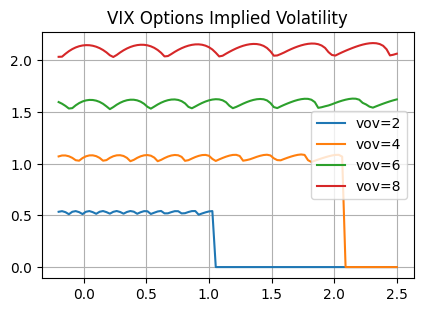

In [27]:
iv_vov = np.zeros((len(vovs), log_moneyness.shape[0]))
for i in range(len(vovs)):
    strike_array = np.exp(log_moneyness)*VIX_Future_prices_vov[i]
    iv_vov[i] = vec_find_vol_rat(VIX_Options_prices_vov[i], VIX_Future_prices_vov[i], strike_array, T, 0, 'c')

plt.plot(log_moneyness, iv_vov.T)
plt.title("VIX Options Implied Volatility")
plt.legend([f'vov={_}' for _ in vovs])
plt.grid()

The vol-of-vol, parameter `vov`, is a constant in the two-factor Bergomi model. The implied volatility of VIX is also a constant from the results above.

When vol-of-vol increases, the VIX becomes more volatile, VIX Futures' prices drop slightly, but the VIX options' prices increase. The implied volatility is a constant approximately proportional to the vov parameter(the drop down in high moneyness for low vovs might be because the option prices are all 0 and the implied volatility is unable to be computed).

VIX Future price for k1=5: 0.13019670341267095
VIX Future price for k1=10: 0.14724338694985808
VIX Future price for k1=20: 0.15491075946675686
VIX Future price for k1=30: 0.15669675564076802


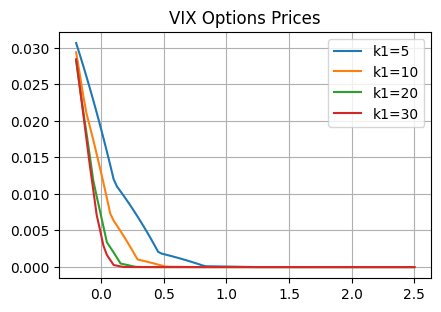

In [28]:
# theta = 0, one-factor Bergomi model
# varying k1
theta_new = 0
k1s = [5, 10, 20, 30]
VIX_Future_prices_k1 = np.zeros(len(k1s))
VIX_Options_prices_k1 = np.zeros((len(k1s), log_moneyness.shape[0]))

for i, k1_new in enumerate(k1s):
    VIX_Future_prices_k1[i], VIX_Options_prices_k1[i] = VIX_Futures_Options(tau, Ts[-1], xi_0, vov, theta_new, k1_new, k_2, rho_x1x2, 10)
    print(f'VIX Future price for k1={k1_new}: {VIX_Future_prices_k1[i]}')

plt.plot(log_moneyness, VIX_Options_prices_k1.T)
plt.title("VIX Options Prices")
plt.legend([f'k1={_}' for _ in k1s])
plt.grid()

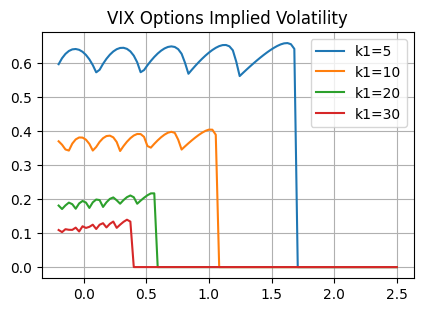

In [29]:
iv_k1 = np.zeros((len(k1s), log_moneyness.shape[0]))
for i in range(len(k1s)):
    strike_array = np.exp(log_moneyness)*VIX_Future_prices_k1[i]
    iv_k1[i] = vec_find_vol_rat(VIX_Options_prices_k1[i], VIX_Future_prices_k1[i], strike_array, Ts[-1], 0, 'c')

plt.plot(log_moneyness, iv_k1.T)
plt.title("VIX Options Implied Volatility")
plt.legend([f'k1={_}' for _ in k1s])
plt.grid()

`k_1` parameter means the mean-reversion of the one-factor Bergomi model. The higher k_1, the faster mean-reverting, the lower implied volatility of VIX options. 